In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from scipy.stats import t
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Collect data
data = fetch_california_housing()
X = data.data
y = data.target
# Visualize data
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


----
----
# Question 1
## A-

The normal equation is given by :
$\boxed{X^TX\hat{\theta}=X^Ty}$

In [3]:
X_bias = np.c_[np.ones((X.shape[0], 1)), X]
theta = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y

# Compute prediction
y_pred = X_bias @ theta

sklearn_mse = mean_squared_error(y, y_pred)
sklearn_r2 = r2_score(y, y_pred)

print("\nMSE using sklearn Linear Regression:", sklearn_mse)
print("R2 using sklearn Linear Regression:", sklearn_r2)


MSE using sklearn Linear Regression: 0.5243209861846071
R2 using sklearn Linear Regression: 0.6062326851998051


----
#B-

Let's check that we can use a Gaussian model.

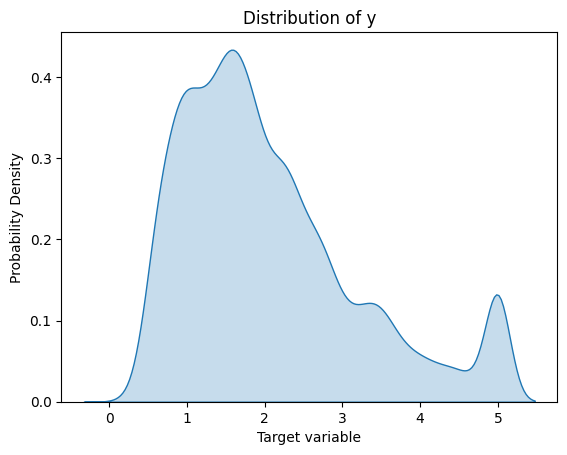

In [4]:
sns.kdeplot(y, fill=True)

# Add labels and title
plt.xlabel('Target variable')
plt.ylabel('Probability Density')
plt.title('Distribution of y')
plt.show()

We will now assume the model to be Gaussian. Let's check now that $\text{Ker}(X) = \{0\}$.

In [5]:
_, singular_values, _ = np.linalg.svd(X)
ker_zero = np.all(singular_values > 1e-10)  # All singular values are higher than a tolerance

if ker_zero:
    print("X kernel is null.")
else:
    print("X kernel is not null.")

X kernel is null.



Therefore, the confidence interval is given by : $\boxed{\hat{\theta_{n,k}} + [-(\frac{\hat{s}_{n,k}\hat{\sigma_n}}{n^{1/2}})Q_{n-p-1}(1-\frac{\alpha}2), (\frac{\hat{s}_{n,k}\hat{\sigma_n}}{n^{1/2}})Q_{n-p-1}(1-\frac{\alpha}2)]}$

with $\hat{s_{n,k}}^2 = e_k^T\hat{G_n}^{-1}e_k$

In [6]:
model = LinearRegression()
model.fit(X_bias, y)

n=X_bias.shape[0]
p=X_bias.shape[1]-1
alpha = 0.01
deg_f = n-p-1

Gn=X_bias.T@X_bias/(n)
est_err = np.sqrt(np.linalg.norm((y-model.predict(X_bias))**2) / deg_f)
q = t.ppf(1-alpha/2, deg_f)

for k in range(1, p+1):
  ek=np.zeros(p+1)
  ek[k]=1
  CI_up = theta[k] + np.sqrt(np.abs(ek.T@np.linalg.inv(Gn)@ek))*est_err/np.sqrt(n)*q
  CI_low = theta[k] - np.sqrt(np.abs(ek.T@np.linalg.inv(Gn)@ek))*est_err/np.sqrt(n)*q
  print("Confidence Interval colonne {}: [{}, {}]".format(k, CI_low, CI_up))

Confidence Interval colonne 1: [0.4352575195998044, 0.43812906667379026]
Confidence Interval colonne 2: [0.00928310080531259, 0.009588455261468343]
Confidence Interval colonne 3: [-0.10933549594760265, -0.1053085868399584]
Confidence Interval colonne 4: [0.6354404125463651, 0.6546909745153435]
Confidence Interval colonne 5: [-5.601143701197944e-06, -2.3516351404569434e-06]
Confidence Interval colonne 6: [-0.003953292767465747, -0.003619792542521147]
Confidence Interval colonne 7: [-0.42377650653194504, -0.4188522485040597]
Confidence Interval colonne 8: [-0.43709084123414355, -0.43193666809501674]


----
----
#Question 2
## A-



In [7]:
# Load the data
filepath='/data.csv'
df = pd.read_csv(filepath)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_bias = np.c_[np.ones((X.shape[0], 1)), X]

In [51]:
#25% of test
X_train, X_test, y_train, y_test = train_test_split(X_bias, y, test_size=0.25, random_state=0)

scaler = StandardScaler()

# Fit and transform on the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing set
X_test_scaled = scaler.transform(X_test)

# Convert pandas Series to NumPy array
y_train_array = y_train.to_numpy().reshape(-1, 1)
y_test_array = y_test.to_numpy().reshape(-1, 1)

# Standardize the target variable (y_train and y_test)
scaler_Y = StandardScaler()
y_train_scaled= scaler_Y.fit_transform(y_train_array).flatten()  # we use flatten() to ensure the right dimension of Y_test an Y_train
y_test_scaled = scaler_Y.transform(y_test_array).flatten()

----
##B-

In [9]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

----
----
#Question 3
##A-B-C-

Under the Gaussian model, the statistic and reject region are given by : $\hat{T}_{n,k}= (\frac{n^{1/2}}{\hat{s}_{n,k}\hat{\sigma_n}})|\hat{\theta_{n,k}}|$ and $R_\alpha=(Q_{n-p-1}(1-\frac \alpha 2), +∞)$.

The code further is based on the part 3.3 of the lecture notes.

In [55]:
from scipy.stats import t

def forward_variable_selection(X, y):
  X = X.values
  r = y
  S = []
  n = X.shape[0]
  p = X.shape[1]
  deg_f = n - p - 1

  five_it_p_values=[]
  five_it_coeffs=[]
  selected_features=[]
  index_features=[]

  it=0

  e1 = np.array([1,0])
  best_p_value = 0.05 #to enter in the loop
  while X.shape[1] > 1 and best_p_value <= 0.05:
    p_values = []
    coeffs=[]
    best_p_value = 1
    selected_coeff=None
    for k in range(X.shape[1]):
      # Select only the k-th feature
      Xk = X[:, k].reshape(-1,1)
      Xk_bias = np.c_[np.ones((Xk.shape[0], 1)), Xk]

      #compute statistics
      Gn = Xk_bias.T @ Xk_bias / n
      s = np.sqrt(np.abs(e1.T@np.linalg.inv(Gn)@e1))

      model = LinearRegression()
      model.fit(Xk_bias, r)

      est_err = np.sqrt(np.linalg.norm((r - model.predict(Xk_bias)) ** 2))/(n-2)

      theta = np.linalg.inv(Xk.T @ Xk) @ Xk.T @ r

      T = theta/(s*est_err)

      #compute the p_value and select it if it is smaller than the best one
      p_value = 2 * (1 - t.cdf(np.abs(T), n-2))
      if(it<5):
        p_values.append(p_value)
        coeffs.append(theta)

      if(p_value<best_p_value):
        best_p_value = p_value
        selected_feature = Xk
        selected_index = k
        res = model.predict(Xk_bias)

    selected_features.append(selected_feature)
    index_features.append(selected_index)
    S.append(Xk)
    X=np.delete(X,selected_index, axis=1)
    r = r - res

    if(it<5):
      five_it_p_values.append(p_values)
      five_it_coeffs.append(coeffs)

    it+=1

  return(selected_features, index_features, five_it_p_values, five_it_coeffs)


> The reason for substracting the residuals is to prevent from selecting 2 identical covariates. The p_value is the smallest value of $\alpha$ for which we still reject the hypothesis, ie the test statistic is in the reject region.

[0.67302919], [-1.93847913], [-1.42716783], [-0.83030083], [-1.08218016], [-0.54875493], [-0.40288615], [-1.43655059], [0.79190867], [-0.93853666], [-2.19529076], [-0.55351103], [0.44538617], [-1.07222496], [-0.87491655], [0.13381863], [0.11134556], [-0.03956713], [1.34464208], [0.69588351], [0.51732478], [-0.04905089], [0.56601831], [-0.17762425], [-0.76833588], [-0.94153847], [-1.49357313], [0.67888375], [0.34078874], [0.85715764], [-0.23458255], [0.24821288], [-0.03209603]


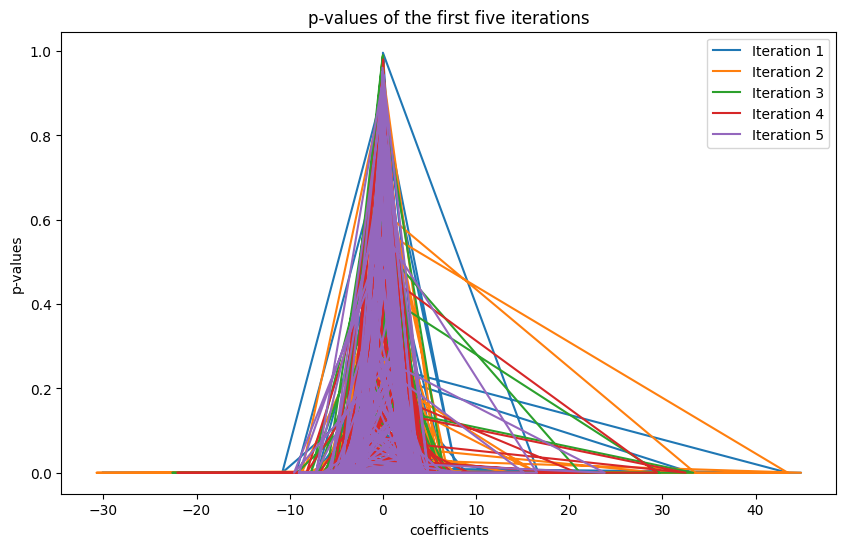

In [58]:
features, index_features, five_it_p_values, five_it_coeffs = forward_variable_selection(X,y)
print(', '.join(str(elem[0]) for elem in features))
fig, ax = plt.subplots(figsize=(10, 6))
iteration=0
for i in range(5):
    ax.plot(five_it_coeffs[i], five_it_p_values[i], label=f'Iteration {i+1}')
    iteration+=1
    if iteration > 4:
        break

# Plot the p_values
ax.set_xlabel('coefficients')
ax.set_ylabel('p-values')
ax.set_title('p-values of the first five iterations')
ax.legend()


----
----
# Question 4

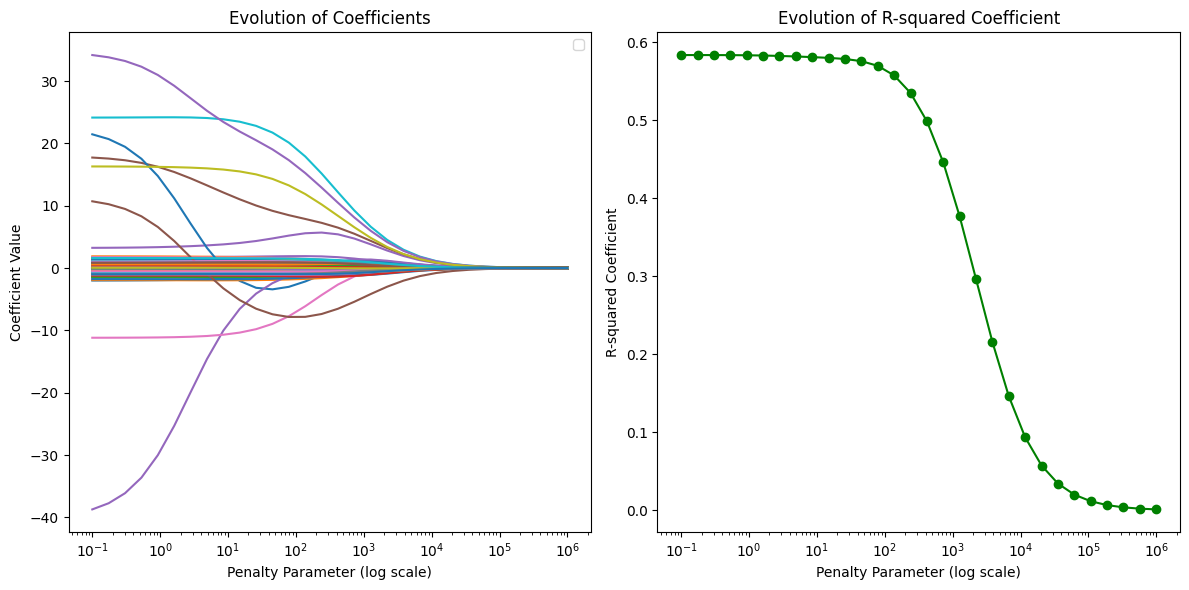

(array([[ 0.00000000e+00,  4.72880242e-01, -5.26864305e-01, ...,
          5.64085577e-02,  1.61405573e+00, -1.00337018e+00],
        [ 0.00000000e+00,  4.69432138e-01, -5.25663471e-01, ...,
          5.62220197e-02,  1.61295974e+00, -1.00180049e+00],
        [ 0.00000000e+00,  4.63822382e-01, -5.23723153e-01, ...,
          5.59265654e-02,  1.61116881e+00, -9.99261574e-01],
        ...,
        [ 0.00000000e+00, -4.52688255e-04, -2.46313245e-03, ...,
         -7.69932458e-04,  8.00871186e-03, -5.75858313e-03],
        [ 0.00000000e+00, -2.61572323e-04, -1.41661155e-03, ...,
         -4.42959942e-04,  4.60338951e-03, -3.30977894e-03],
        [ 0.00000000e+00, -1.50670892e-04, -8.13819647e-04, ...,
         -2.54522782e-04,  2.64370030e-03, -1.90070736e-03]]),
 array([0.58375302, 0.5837427 , 0.58371452, 0.58364286, 0.58347912,
        0.58315706, 0.58263175, 0.58192766, 0.58111078, 0.58015124,
        0.57872544, 0.57594073, 0.56994606, 0.55767218, 0.53522528,
        0.49890842, 0.446

In [12]:
from sklearn.linear_model import Ridge

def perform_regression(X_train_scaled, X_test_scaled, y_train, y_test, penalty_params, regression_type):
  coefficients = []
  r_squared_values = []

  for alpha in penalty_params:
    if regression_type == 'ridge':
      model = Ridge(alpha=alpha)
    elif regression_type == 'lasso':
      model = Lasso(alpha=alpha)
    elif regression_type == 'elastic_net':
      model = ElasticNet(alpha=alpha, l1_ratio=0.5)
    else:
      raise ValueError("Invalid regression type. Must be 'ridge', 'lasso' or 'elastic_net'.")

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_train_scaled)
    coefficients.append(model.coef_)
    r_squared = r2_score(y_train, y_pred)
    r_squared_values.append(r_squared)

  coefficients = np.array(coefficients)
  r_squared_values = np.array(r_squared_values)

  # Plot the evolution of the coefficients
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(penalty_params, coefficients)
  plt.xscale('log')
  plt.xlabel('Penalty Parameter (log scale)')
  plt.ylabel('Coefficient Value')
  plt.title('Evolution of Coefficients')
  plt.legend()

  # Plot the evolution of the R-squared coefficient
  plt.subplot(1, 2, 2)
  plt.plot(penalty_params, r_squared_values, color='green', marker='o')
  plt.xscale('log')
  plt.xlabel('Penalty Parameter (log scale)')
  plt.ylabel('R-squared Coefficient')
  plt.title('Evolution of R-squared Coefficient')

  # Show the plots
  plt.tight_layout()
  plt.show()

  return coefficients, r_squared_values

perform_regression(X_train, X_test, y_train, y_test, penalty_params = np.logspace(-1, 6, num=30), regression_type='ridge')

----
----
# Question 5

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.724e+04, tolerance: 1.963e

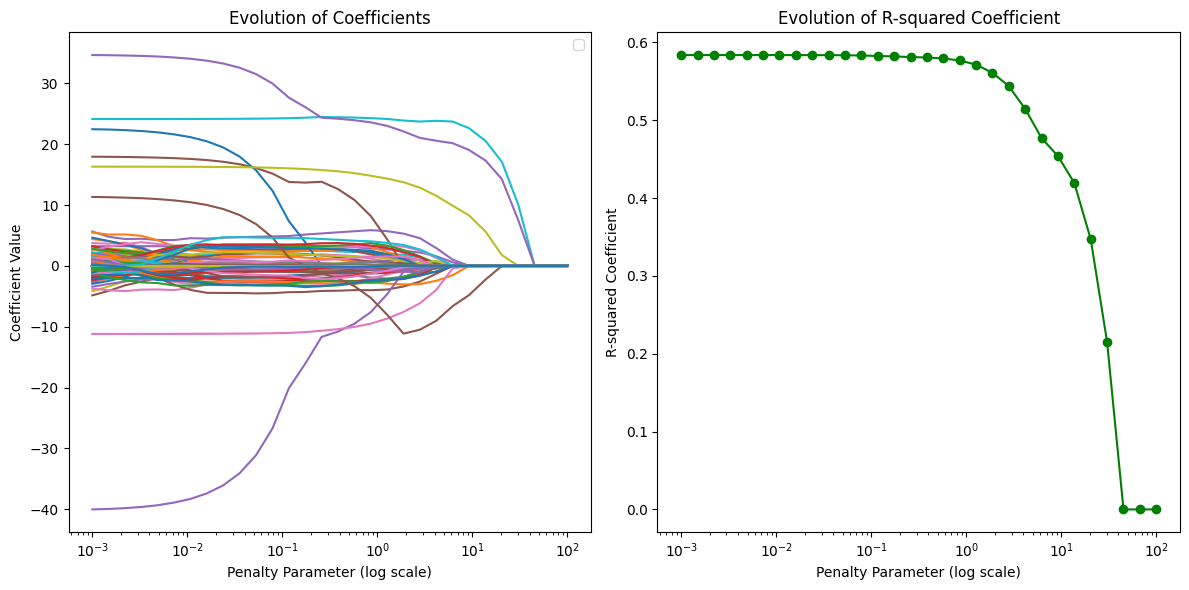

(array([[ 0.        , -0.22142746, -1.92089511, ...,  0.        ,
          0.04730972,  0.17985171],
        [ 0.        ,  0.33359714, -1.62728361, ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.85559676, ...,  0.        ,
          0.0279957 , -0.19502118],
        ...,
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ]]),
 array([0.58375847, 0.5837584 , 0.5837582 , 0.58375772, 0.58375658,
        0.58375396, 0.58374844, 0.58373609, 0.58370911, 0.58364945,
        0.58351716, 0.58322415, 0.58257185, 0.58201876, 0.58119503,
        0.58063141, 0.57942091, 0.57678473, 0.57149211, 0.56093738,
        0.54384119, 0.51451785, 0.47705999, 0.45393904, 0.41933898,
        0.34715165, 0.21513271, 0

In [13]:
from sklearn.linear_model import Lasso

perform_regression(X_train, X_test, y_train, y_test, penalty_params = np.logspace(-3, 2, num=30), regression_type='lasso')

----
----
# Question 6

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.797e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+05, tolerance: 1.963e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+05, tolerance: 1.963e

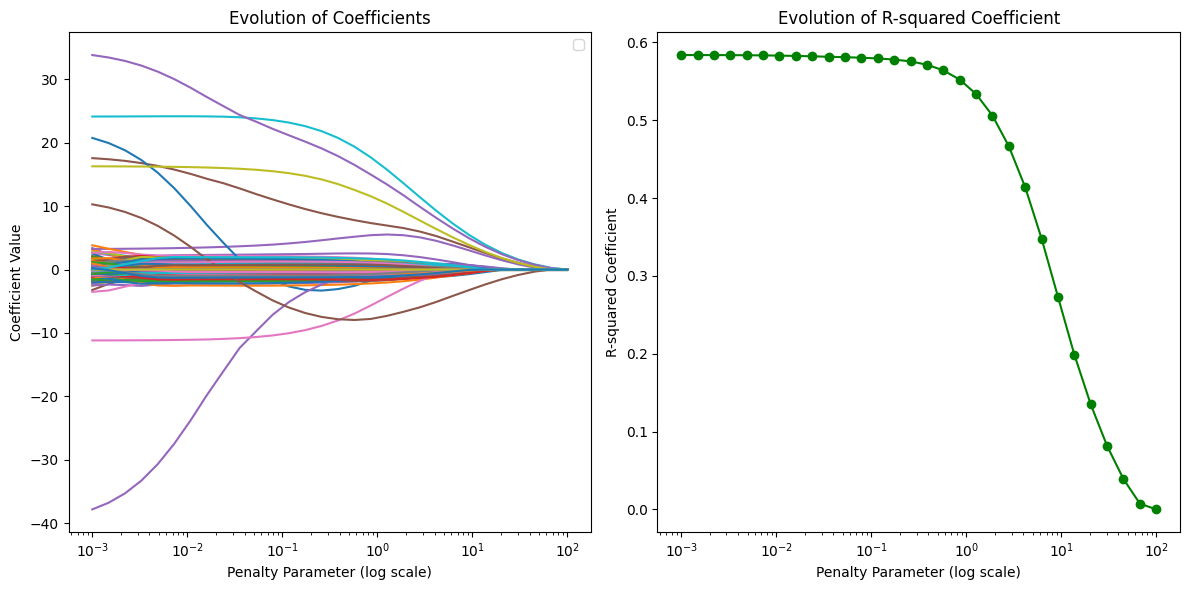

(array([[ 0.        ,  0.09979576, -1.29224784, ...,  0.        ,
          0.02961065,  0.20296007],
        [ 0.        ,  0.50296452, -0.7424091 , ...,  0.        ,
          0.31623369, -0.08391699],
        [ 0.        ,  0.42210702, -0.29775175, ...,  0.        ,
          0.83682748, -0.54636319],
        ...,
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ],
        [ 0.        , -0.        , -0.        , ..., -0.        ,
          0.        , -0.        ]]),
 array([0.58374405, 0.58372782, 0.58369464, 0.5836304 , 0.58351416,
        0.58332059, 0.58302441, 0.58261369, 0.58213876, 0.58156262,
        0.58101506, 0.58030269, 0.57937816, 0.57797483, 0.57559572,
        0.57140117, 0.56411205, 0.55224526, 0.53366686, 0.50604063,
        0.46666351, 0.41398964, 0.3480331 , 0.27320136, 0.19887866,
        0.13498268, 0.08160643, 0

In [14]:
from sklearn.linear_model import Lasso, ElasticNet

perform_regression(X_train, X_test, y_train, y_test, penalty_params = np.logspace(-3, 2, num=30), regression_type='elastic_net')

----
----
# Question 7

We use the notation $ U, s, V = SVD(X^\intercal X)$.

##A-

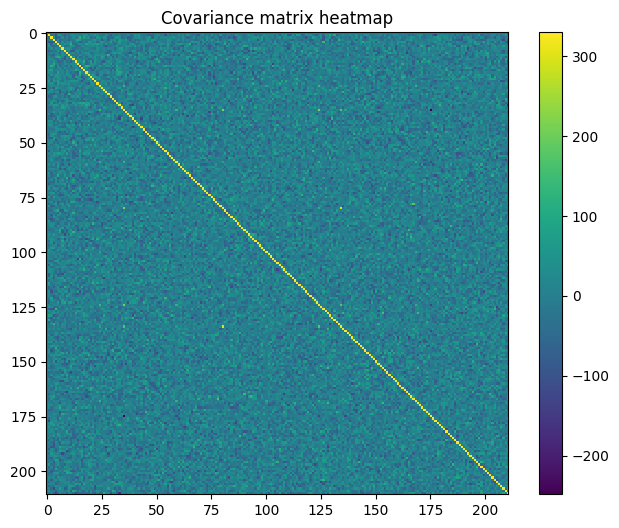

In [15]:
from sklearn.decomposition import PCA

U, s, V = np.linalg.svd(X_train_scaled.T@X_train_scaled)

plt.figure(figsize=(8, 6))
plt.imshow(X_train_scaled.T@X_train_scaled, cmap='viridis', interpolation='nearest')
plt.title('Covariance matrix heatmap')
plt.colorbar()
plt.show()


----
##B-

In [23]:
def PCA(X,k=None):
    U, s, V = np.linalg.svd(X.T @ X)
    if k is None:
        return X @ V.T
    else:
        return X @ V[:k, :].T

----
##C-

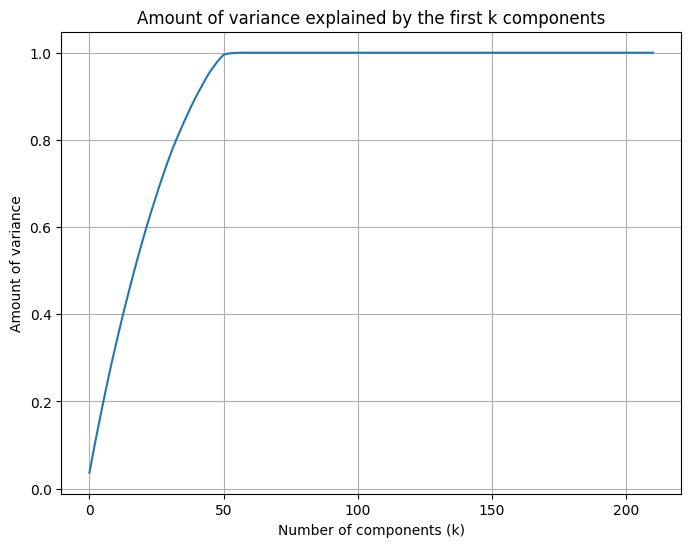

In [24]:
explained_variance_ratio = (s ** 2) / np.sum(s ** 2)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of components (k)')
plt.ylabel('Amount of variance')
plt.title('Amount of variance explained by the first k components')
plt.grid(True)
plt.show()

In [25]:
num_90 = np.argmax(np.cumsum(explained_variance_ratio) > 0.90) + 1
print(f"Number of variables needed to explain more than 90% of the variance: {num_90}")

Number of variables needed to explain more than 90% of the variance: 41


----
#D-

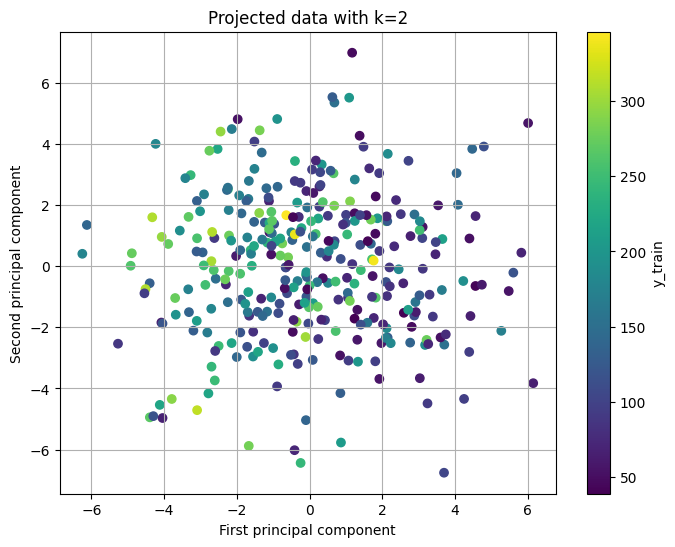

In [35]:
X_proj = PCA(X_train_scaled, 2)

plt.figure(figsize=(8, 6))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_train, cmap='viridis')  # Color points based on y values
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projected data with k=2')
plt.colorbar(label='y_train')  # Add colorbar to show the mapping of y values to colors
plt.grid(True)
plt.show()

> We can see that the scatterplot is similarly extended parallel to the first principal component and parallel to the second. This indicates that the variance of the data is similar in both directions.

----
##E-

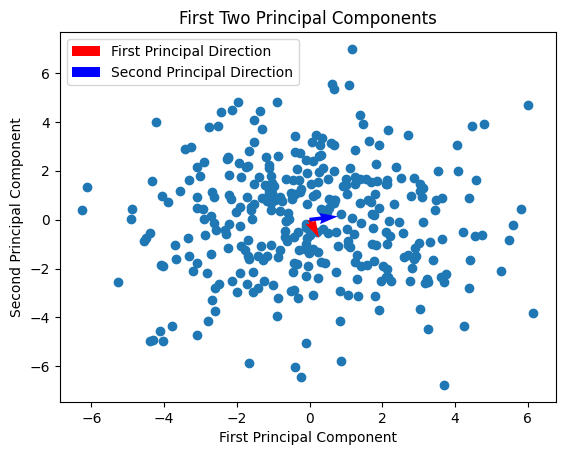

In [50]:
# plot the two principal dimensions of the PCA
v0=PCA(X_train_scaled,2)[:,0]*np.sqrt(explained_variance_ratio[0])
v1=PCA(X_train_scaled,2)[:,1]*np.sqrt(explained_variance_ratio[1])

plt.scatter(X_proj[:, 0], X_proj[:, 1])
plt.quiver(0, 0, v0[0], v0[1],color='red', angles='xy', scale_units='xy', scale=1, label='First Principal Direction')
plt.quiver(0, 0, v1[0], v1[1], color='blue', angles='xy', scale_units='xy', scale=1, label='Second Principal Direction')
plt.legend()
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components')
plt.show()

> We can see that directions are almost orthogonal. This is consistent with the previous interpretation.

----
##F-

>

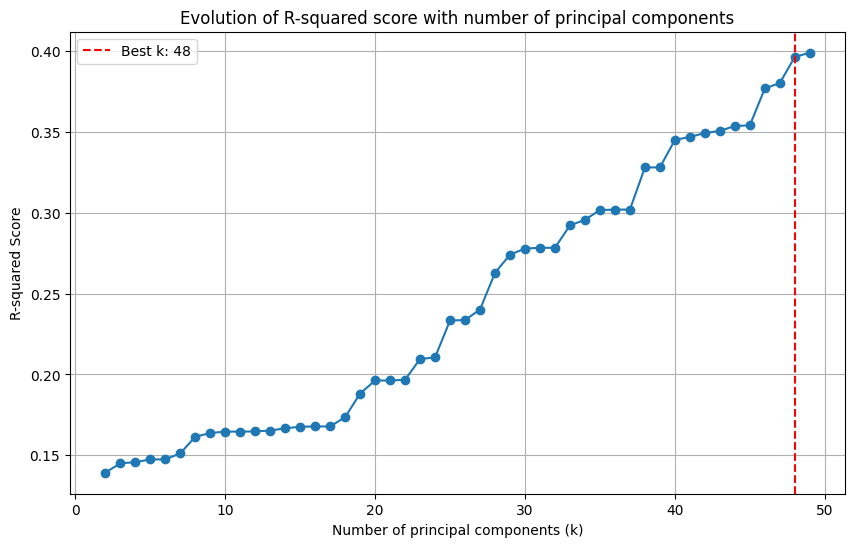

The best k that returns the highest R-squared score is: 48


In [53]:
scores = []

for k in range(2, 50):
  X_proj = PCA(X_train_scaled, k)
  # Fit OLS model
  model = LinearRegression()
  model.fit(X_proj, y_train)

  # Predict using the OLS model
  y_pred = model.predict(X_proj)

  # Evaluate the performance using R-squared score
  score = r2_score(y_train, y_pred)
  scores.append(score)

# Find the best k
best_k = scores.index(max(scores)) + 1

# Plot the evolution of scores with k
plt.figure(figsize=(10, 6))
plt.plot(range(2, 50), scores, marker='o', linestyle='-')
plt.xlabel('Number of principal components (k)')
plt.ylabel('R-squared Score')
plt.title('Evolution of R-squared score with number of principal components')
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k: {best_k}')
plt.legend()
plt.grid(True)
plt.show()

print(f"The best k that returns the highest R-squared score is: {best_k}")

----
----
#Question 8-

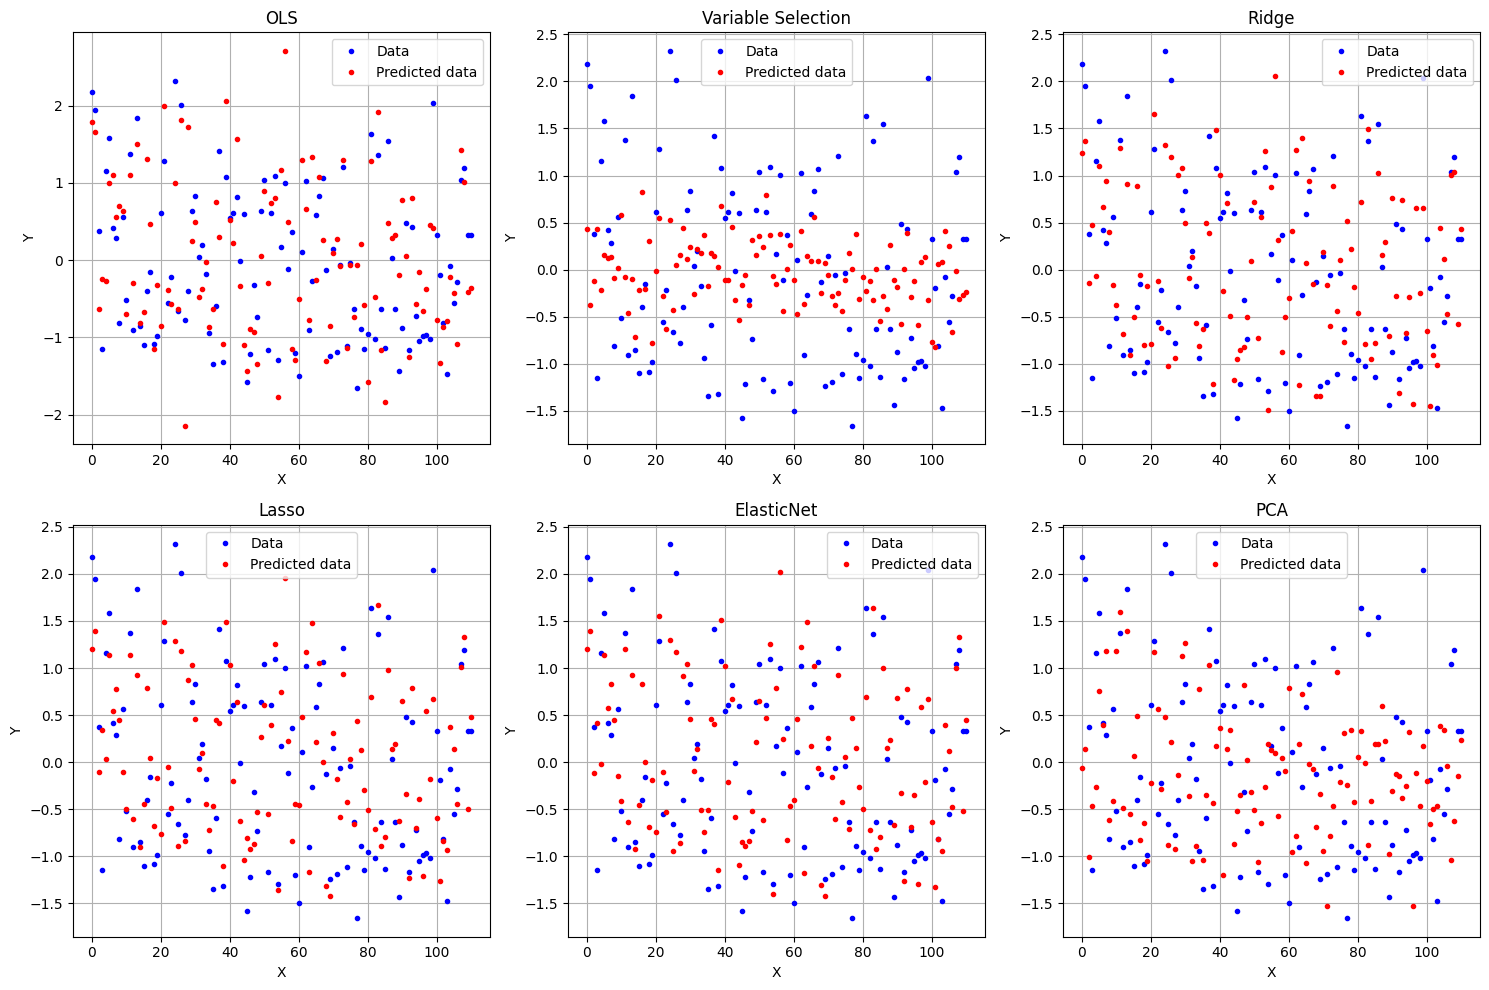

In [59]:
plt.figure(figsize=(15, 10))

# OLS
OLS = LinearRegression()
OLS.fit(X_train_scaled, y_train_scaled)

plt.subplot(2, 3, 1)
plt.plot(y_test_scaled, 'b.', label='Data')
plt.plot(OLS.predict(X_test_scaled), 'r.', label='Predicted data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('OLS')
plt.legend()
plt.grid(True)

# Variable Selection
variable_selection = LinearRegression()
variable_selection.fit(X_train_scaled[:, index_features], y_train_scaled)

plt.subplot(2, 3, 2)
plt.plot(y_test_scaled, 'b.', label='Data')
plt.plot(variable_selection.predict(X_test_scaled[:, index_features]), 'r.', label='Predicted data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Variable Selection')
plt.legend()
plt.grid(True)

# Ridge
Ridge_ = Ridge(alpha=alpha)
Ridge_.fit(X_train_scaled, y_train_scaled)

plt.subplot(2, 3, 3)
plt.plot(y_test_scaled, 'b.', label='Data')
plt.plot(Ridge_.predict(X_test_scaled), 'r.', label='Predicted data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ridge')
plt.legend()
plt.grid(True)

# Lasso
Lasso_ = Lasso(alpha=alpha)
Lasso_.fit(X_train_scaled, y_train_scaled)

plt.subplot(2, 3, 4)
plt.plot(y_test_scaled, 'b.', label='Data')
plt.plot(Lasso_.predict(X_test_scaled), 'r.', label='Predicted data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Lasso')
plt.legend()
plt.grid(True)

# ElasticNet
ElasticN_ = ElasticNet(alpha=alpha, l1_ratio=0.5)
ElasticN_.fit(X_train_scaled, y_train_scaled)

plt.subplot(2, 3, 5)
plt.plot(y_test_scaled, 'b.', label='Data')
plt.plot(ElasticN_.predict(X_test_scaled), 'r.', label='Predicted data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('ElasticNet')
plt.legend()
plt.grid(True)

# PCA
PCR = LinearRegression()
PCR.fit(PCA(X_train_scaled,best_k), y_train_scaled)

plt.subplot(2, 3, 6)
plt.plot(y_test_scaled, 'b.', label='Data')
plt.plot(PCR.predict(PCA(X_test_scaled,best_k)), 'r.', label='Predicted data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('PCA')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

>The OLS and Forward Variable Selection models both exhibit scattered predictions, showing deviations from the ideal line y = x.

>Ridge and Lasso regression models demonstrate slightly tighter clusters of predictions around actual points, indicating potential improvements over basic OLS. Lasso may perform better for lower target values due to its sparser solutions.

>The ElasticNet model, combining L1 and L2 regularization, shows a similar scatter pattern to Ridge and Lasso.

>PCA-based predictions display significant dispersion, suggesting that the prediction accuracy in this dataset was not enhanced.

Model: OLS Model
Train MSE: 0.6086533749818513
Test MSE: 0.6739823034987236

Model: Variable Selection
Train MSE: 0.8959013398226798
Test MSE: 1.0134077173639604

Model: Ridge Regression
Train MSE: 0.41624154908734706
Test MSE: 0.583496756330423

Model: Lasso Regression
Train MSE: 0.4223586892957121
Test MSE: 0.542057786478362

Model: ElasticNet Regression
Train MSE: 0.41959232717322903
Test MSE: 0.5575704396166185

Model: PCA
Train MSE: 0.6036905368721467
Test MSE: 0.88974263492127



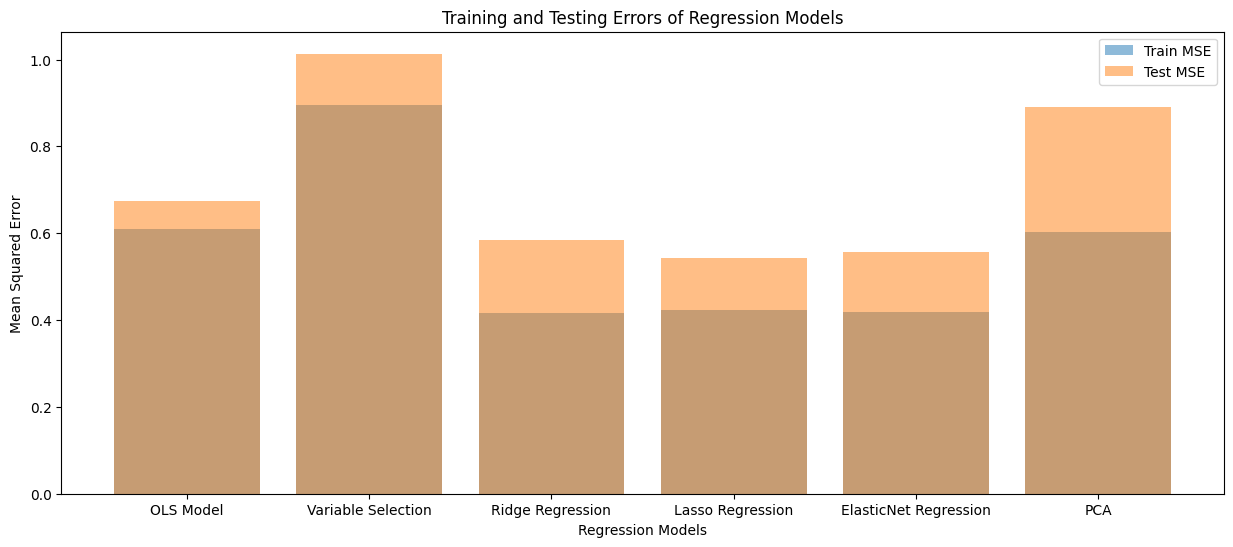

In [82]:
from sklearn.decomposition import PCA

models = {
    'OLS Model': LinearRegression(),
    'Variable Selection' : LinearRegression(),
    'Ridge Regression': Ridge(alpha=alpha),
    'Lasso Regression': Lasso(alpha=alpha),
    'ElasticNet Regression': ElasticNet(alpha=alpha, l1_ratio=0.5),
    'PCA' : LinearRegression()
}

# Train models and evaluate performance
train_errors = {}
test_errors = {}

for name, model in models.items():
    if (name=='Variable Selection'):
      model.fit(X_train_scaled[:, index_features], y_train_scaled)
      y_train_pred = model.predict(X_train_scaled[:, index_features])
      y_test_pred = model.predict(X_test_scaled[:, index_features])
    elif(name=='PCA'):
      pca = PCA(n_components=best_k)
      X_train_pca = pca.fit_transform(X_train_scaled)
      X_test_pca = pca.transform(X_test_scaled)
      model = LinearRegression()
      model.fit(X_train_pca, y_train_scaled)
      y_train_pred = model.predict(X_train_pca)
      y_test_pred = model.predict(X_test_pca)
    else:
      model.fit(X_train_scaled, y_train_scaled)
      y_train_pred = model.predict(X_train_scaled)
      y_test_pred = model.predict(X_test_scaled)

    train_errors[name] = mean_squared_error(y_train_scaled, y_train_pred)
    test_errors[name] = mean_squared_error(y_test_scaled, y_test_pred)

    # Print performance metrics
    print(f"Model: {name}")
    print(f"Train MSE: {train_errors[name]}")
    print(f"Test MSE: {test_errors[name]}")
    print()

# Plotting training and testing errors
plt.figure(figsize=(15, 6))
plt.bar(range(len(train_errors)), list(train_errors.values()), align='center', alpha=0.5, label='Train MSE')
plt.bar(range(len(test_errors)), list(test_errors.values()), align='center', alpha=0.5, label='Test MSE')
plt.xticks(range(len(train_errors)), list(train_errors.keys()))
plt.xlabel('Regression Models')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Errors of Regression Models')
plt.legend()
plt.show()

> We can see that the best models for the mean squared error are Ridge, Lasso and ElasticNet.